# Mini-Projet: Apriori & FP-Growth Algorithms


---

## Part 1: Setup and Data Preprocessing

In [ ]:
# Import required libraries
import sys
import os
sys.path.append(os.path.abspath('src'))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

# Import custom modules
from data_preprocessing import load_and_preprocess, segment_by_country, print_sample_transactions
from apriori_fpgrowth import AprioriAlgorithm, FPGrowth, generate_association_rules, rules_to_dataframe
from analysis import sensitivity_analysis, plot_sensitivity_analysis, compare_segments, plot_top_rules, print_rule_insights

# Configure display settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 50)
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

print("✓ All libraries imported successfully!")

In [ ]:
# Load and preprocess the Online Retail dataset

SAMPLE_SIZE = None  

transactions, df_clean = load_and_preprocess("data/Online Retail.xlsx", sample_size=SAMPLE_SIZE)

print(f"\n✓ Dataset loaded and preprocessed!")
print(f"Total transactions: {len(transactions):,}")
print(f"Unique products: {df_clean['Description'].nunique():,}")

Loading dataset from Online Retail.xlsx...
Original dataset shape: (541909, 8)
Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

=== Data Cleaning ===
Removed 1454 rows with missing InvoiceNo/StockCode/Description
Removed cancelled orders, remaining: 531167 rows
Removed negative/zero quantities, remaining: 530693 rows
Removed non-product items, remaining: 528497 rows

Final cleaned dataset shape: (528497, 8)
Unique invoices: 19969
Unique products: 4052

=== Transforming to Transaction Format ===
Total transactions: 19969
Average items per transaction: 26.47
Max items in a transaction: 1113
Min items in a transaction: 1

✓ Dataset loaded and preprocessed!
Total transactions: 19,969
Unique products: 4,052


In [3]:
# Display sample transactions
print_sample_transactions(transactions, n=5)


=== Sample Transactions (first 5) ===
Transaction 1: 7 items
  Items: ['WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN', 'CREAM CUPID HEARTS COAT HANGER', 'KNITTED UNION FLAG HOT WATER BOTTLE', 'RED WOOLLY HOTTIE WHITE HEART.']...
Transaction 2: 2 items
  Items: ['HAND WARMER UNION JACK', 'HAND WARMER RED POLKA DOT']
Transaction 3: 12 items
  Items: ['ASSORTED COLOUR BIRD ORNAMENT', "POPPY'S PLAYHOUSE BEDROOM", "POPPY'S PLAYHOUSE KITCHEN", 'FELTCRAFT PRINCESS CHARLOTTE DOLL', 'IVORY KNITTED MUG COSY']...
Transaction 4: 4 items
  Items: ['JAM MAKING SET WITH JARS', 'RED COAT RACK PARIS FASHION', 'YELLOW COAT RACK PARIS FASHION', 'BLUE COAT RACK PARIS FASHION']
Transaction 5: 1 items
  Items: ['BATH BUILDING BLOCK WORD']


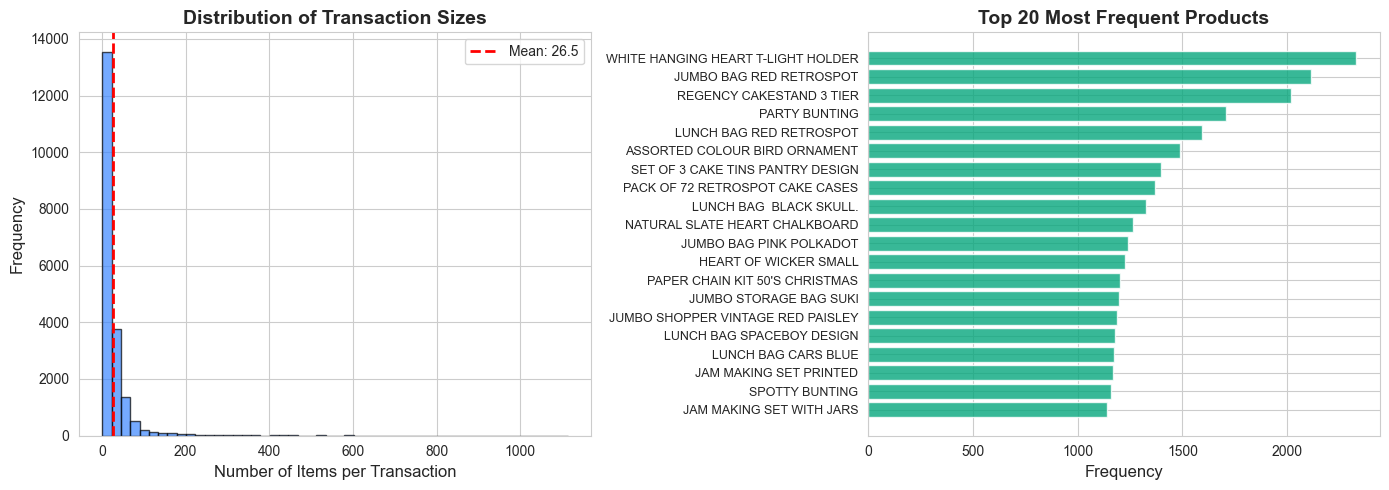

✓ Exploratory analysis complete!


In [4]:
# Visualize transaction distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Transaction size distribution
transaction_sizes = [len(t) for t in transactions]
axes[0].hist(transaction_sizes, bins=50, color='#3A86FF', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Number of Items per Transaction', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Transaction Sizes', fontsize=14, fontweight='bold')
axes[0].axvline(np.mean(transaction_sizes), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(transaction_sizes):.1f}')
axes[0].legend()

# Top 20 most frequent items
item_counts = df_clean['Description'].value_counts().head(20)
axes[1].barh(range(len(item_counts)), item_counts.values, color='#06A77D', alpha=0.8)
axes[1].set_yticks(range(len(item_counts)))
axes[1].set_yticklabels([label[:40] for label in item_counts.index], fontsize=9)
axes[1].set_xlabel('Frequency', fontsize=12)
axes[1].set_title('Top 20 Most Frequent Products', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('results/exploratory_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Exploratory analysis complete!")

## Part 0: Apriori on small demo dataset (order_data.csv)

This short section runs Apriori on the small `data/order_data.csv` file provided with the repository using example parameters from the assignment (min_support=0.25, min_confidence=0.2, min_lift=2).

In [ ]:
# Small demo: Apriori on data/order_data.csv
from pathlib import Path
# Read simple space-separated transactions file (one transaction per line)
orders_path = Path('data/order_data.csv')
transactions_demo = []
with orders_path.open('r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split()
        if parts:
            transactions_demo.append([p.strip().upper() for p in parts])

print(f'Total demo transactions: {len(transactions_demo)}')

# Parameters from assignment example
MIN_SUPPORT_DEMO = 0.25
MIN_CONFIDENCE_DEMO = 0.2
MIN_LIFT_DEMO = 2.0

# Run Apriori (our implementation)
apriori_demo = AprioriAlgorithm(min_support=MIN_SUPPORT_DEMO)
freq_itemsets_demo = apriori_demo.fit(transactions_demo)

rules_demo = generate_association_rules(freq_itemsets_demo, apriori_demo.support_data, len(transactions_demo), min_confidence=MIN_CONFIDENCE_DEMO)

# Filter by lift and minimal length (antecedent+consequent >= 2)
filtered = [r for r in rules_demo if r['lift'] >= MIN_LIFT_DEMO and (len(r['antecedent']) + len(r['consequent'])) >= 2]

import pandas as pd
df_demo = pd.DataFrame(filtered)
if not df_demo.empty:
    df_demo['antecedent_str'] = df_demo['antecedent'].apply(lambda x: ', '.join(sorted(list(x))))
    df_demo['consequent_str'] = df_demo['consequent'].apply(lambda x: ', '.join(sorted(list(x))))
    print('Top demo rules (filtered by lift >= 2):')
    print(df_demo[['antecedent_str','consequent_str','support','confidence','lift']].sort_values('lift', ascending=False).to_string(index=False))

    # Interpret the top two rules in plain language
    for i, row in df_demo.sort_values('lift', ascending=False).head(2).iterrows():
        print('
Interpretation:')
        print(f" - Rule: {{row['antecedent_str']}} => {{row['consequent_str']}}")
        print(f"   Support: {{row['support']:.3f}} ({{row['support']*100:.1f}}% of transactions)")
        print(f"   Confidence: {{row['confidence']:.3f}} (given antecedent, probability of consequent)")
        print(f"   Lift: {{row['lift']:.2f}} (lift > 1 means positive association)")
        if row['lift'] > 2:
            print('   Business note: Strong candidate for bundling or cross-sell.')
        elif row['lift'] > 1.2:
            print('   Business note: Good candidate for recommendations.')
else:
    print('No rules in the demo dataset matched the filters (lift >= 2). Consider lowering thresholds for demonstration purposes.')

In [ ]:
# Timing comparison: Apriori vs FP-Growth on a small sample
import time
# Use a small random sample of the real transactions if available, otherwise reuse demo transactions
sample_transactions = transactions if 'transactions' in globals() else transactions_demo
sample_size = min(2000, len(sample_transactions))
if sample_size < len(sample_transactions):
    import numpy as _np
    _np.random.seed(42)
    indices = _np.random.choice(len(sample_transactions), sample_size, replace=False)
    sample = [sample_transactions[i] for i in indices]
else:
    sample = sample_transactions

print(f'Running timing on sample of {len(sample)} transactions...')

# Time Apriori
t0 = time.perf_counter()
apriori_t = AprioriAlgorithm(min_support=0.02)
_ = apriori_t.fit(sample)
t1 = time.perf_counter()
apriori_time = t1 - t0

# Time FP-Growth
t0 = time.perf_counter()
fpg = FPGrowth(min_support=0.02)
_ = fpg.fit(sample)
t1 = time.perf_counter()
fpg_time = t1 - t0

print(f'Apriori elapsed time: {apriori_time:.3f} s')
print(f'FP-Growth elapsed time: {fpg_time:.3f} s')

# Quick comparison output
print('\nSummary:')
print(f' - Apriori found {sum(len(v) for v in apriori_t.frequent_itemsets.values())} frequent itemsets')
print(f' - FP-Growth found {sum(len(v) for v in fpg.frequent_itemsets.values())} frequent itemsets')

if fpg_time > 0:
    print(f'FP-Growth is {apriori_time/fpg_time:.2f}x faster (on this sample)')
else:
    print('FP-Growth time too small to compare reliably')

## Part 2: Apriori Algorithm

In [ ]:
# Apply Apriori algorithm
print("Running Apriori algorithm...")
print("This may take a few minutes depending on dataset size...\n")

MIN_SUPPORT = 0.02  # 2% minimum support
MIN_CONFIDENCE = 0.3  # 30% minimum confidence

apriori = AprioriAlgorithm(min_support=MIN_SUPPORT)
freq_itemsets_apriori = apriori.fit(transactions)

# Display statistics
print(f"\n{'='*60}")
print("APRIORI ALGORITHM RESULTS")
print(f"{'='*60}")
print(f"Minimum Support: {MIN_SUPPORT*100}%")
print(f"Minimum Confidence: {MIN_CONFIDENCE*100}%")
print(f"\nFrequent Itemsets by Size:")
for k, itemsets in sorted(freq_itemsets_apriori.items()):
    print(f"  {k}-itemsets: {len(itemsets):,}")

total_itemsets_apriori = sum(len(itemsets) for itemsets in freq_itemsets_apriori.values())
print(f"\nTotal Frequent Itemsets: {total_itemsets_apriori:,}")

Running Apriori algorithm...
This may take a few minutes depending on dataset size...



In [ ]:
# Generate association rules from Apriori results
print("Generating association rules...\n")

rules_apriori = generate_association_rules(
    freq_itemsets_apriori,
    apriori.support_data,
    len(transactions),
    min_confidence=MIN_CONFIDENCE
)

df_rules_apriori = rules_to_dataframe(rules_apriori)

print(f"Total Association Rules Generated: {len(df_rules_apriori):,}")
print(f"\nTop 10 Rules by Lift:\n")
print(df_rules_apriori.head(10).to_string(index=False))

In [ ]:
# Visualize top rules from Apriori
plot_top_rules(df_rules_apriori, top_n=15, metric='lift', 
               title='Top 15 Association Rules from Apriori (by Lift)',
               save_path='results/apriori_top_rules.png')
plt.show()

In [ ]:
# Print business insights from Apriori rules
print_rule_insights(df_rules_apriori, top_n=5)

## Part 3: FP-Growth Algorithm

In [ ]:
# Apply FP-Growth algorithm
print("Running FP-Growth algorithm...")
print("FP-Growth is typically faster than Apriori...\n")

fpgrowth = FPGrowth(min_support=MIN_SUPPORT)
freq_itemsets_fpgrowth = fpgrowth.fit(transactions)

# Display statistics
print(f"\n{'='*60}")
print("FP-GROWTH ALGORITHM RESULTS")
print(f"{'='*60}")
print(f"Minimum Support: {MIN_SUPPORT*100}%")
print(f"\nFrequent Itemsets by Size:")
for k, itemsets in sorted(freq_itemsets_fpgrowth.items()):
    print(f"  {k}-itemsets: {len(itemsets):,}")

total_itemsets_fpgrowth = sum(len(itemsets) for itemsets in freq_itemsets_fpgrowth.values())
print(f"\nTotal Frequent Itemsets: {total_itemsets_fpgrowth:,}")

In [ ]:
# Generate association rules from FP-Growth results
print("Generating association rules...\n")

rules_fpgrowth = generate_association_rules(
    freq_itemsets_fpgrowth,
    fpgrowth.support_data,
    len(transactions),
    min_confidence=MIN_CONFIDENCE
)

df_rules_fpgrowth = rules_to_dataframe(rules_fpgrowth)

print(f"Total Association Rules Generated: {len(df_rules_fpgrowth):,}")
print(f"\nTop 10 Rules by Lift:\n")
print(df_rules_fpgrowth.head(10).to_string(index=False))

## Part 4: Sensitivity Analysis

In [ ]:
# Perform sensitivity analysis on min_support parameter
print("Performing sensitivity analysis...")
print("Testing different min_support values: 0.01, 0.02, 0.03, 0.05\n")

support_values = [0.01, 0.02, 0.03, 0.05]

df_sensitivity = sensitivity_analysis(
    transactions,
    support_values,
    algorithm='apriori',
    min_confidence=MIN_CONFIDENCE
)

print("\n" + "="*80)
print("SENSITIVITY ANALYSIS RESULTS")
print("="*80)
print(df_sensitivity.to_string(index=False))

In [ ]:
# Visualize sensitivity analysis
plot_sensitivity_analysis(df_sensitivity, save_path='results/sensitivity_analysis.png')
plt.show()

print("\n✓ Sensitivity analysis complete!")

### Sensitivity Analysis Observations

**Key Findings:**
1. As min_support increases, the number of frequent itemsets and rules decreases exponentially
2. Lower support values (0.01-0.02) capture more rare but potentially interesting patterns
3. Higher support values (0.03-0.05) focus on the most common patterns, reducing noise
4. The lift metric tends to be higher for rules found at higher support thresholds
5. Trade-off: Lower support = more rules but more trivial patterns; Higher support = fewer but more reliable patterns

## Part 5: Dataset Segmentation Analysis

In [ ]:
# Segment dataset by country: UK vs Others
print("Segmenting dataset by country...\n")

df_uk, df_others = segment_by_country(df_clean, target_country='United Kingdom')

# Convert to transaction format
transactions_uk = df_uk.groupby('InvoiceNo')['Description'].apply(list).values.tolist()
transactions_others = df_others.groupby('InvoiceNo')['Description'].apply(list).values.tolist()

print(f"\nUK Transactions: {len(transactions_uk):,}")
print(f"Other Countries Transactions: {len(transactions_others):,}")

In [ ]:
# Run Apriori on UK segment
print("\nAnalyzing UK segment...")
apriori_uk = AprioriAlgorithm(min_support=MIN_SUPPORT)
freq_itemsets_uk = apriori_uk.fit(transactions_uk)
rules_uk = generate_association_rules(freq_itemsets_uk, apriori_uk.support_data, 
                                       len(transactions_uk), min_confidence=MIN_CONFIDENCE)
df_rules_uk = rules_to_dataframe(rules_uk)

print(f"UK Rules Generated: {len(df_rules_uk):,}")
print(f"\nTop 5 UK Rules:\n")
print(df_rules_uk.head(5).to_string(index=False))

In [ ]:
# Run Apriori on Others segment
print("\nAnalyzing Other Countries segment...")
apriori_others = AprioriAlgorithm(min_support=MIN_SUPPORT)
freq_itemsets_others = apriori_others.fit(transactions_others)
rules_others = generate_association_rules(freq_itemsets_others, apriori_others.support_data,
                                           len(transactions_others), min_confidence=MIN_CONFIDENCE)
df_rules_others = rules_to_dataframe(rules_others)

print(f"Other Countries Rules Generated: {len(df_rules_others):,}")
print(f"\nTop 5 Other Countries Rules:\n")
print(df_rules_others.head(5).to_string(index=False))

In [ ]:
# Compare segments
comparison = compare_segments(df_rules_uk, df_rules_others, 
                             segment1_name="UK", segment2_name="Other Countries",
                             top_n=10)

print(f"\nCommon Rules (sample):")
for i, rule in enumerate(comparison['common_rules_list'][:5], 1):
    print(f"  {i}. {rule}")

print(f"\nUnique to UK (sample):")
for i, rule in enumerate(comparison['unique_seg1_list'][:5], 1):
    print(f"  {i}. {rule}")

print(f"\nUnique to Other Countries (sample):")
for i, rule in enumerate(comparison['unique_seg2_list'][:5], 1):
    print(f"  {i}. {rule}")

In [ ]:
# Visualize segment-specific rules
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# UK segment
if len(df_rules_uk) > 0:
    top_uk = df_rules_uk.nlargest(10, 'lift')
    top_uk['rule'] = top_uk['antecedent_str'].str[:30] + ' → ' + top_uk['consequent_str'].str[:30]
    axes[0].barh(range(len(top_uk)), top_uk['lift'], color='#FF006E', alpha=0.8)
    axes[0].set_yticks(range(len(top_uk)))
    axes[0].set_yticklabels(top_uk['rule'], fontsize=9)
    axes[0].set_xlabel('Lift', fontsize=12)
    axes[0].set_title('Top 10 Rules: UK Market', fontsize=14, fontweight='bold')
    axes[0].invert_yaxis()

# Other countries segment
if len(df_rules_others) > 0:
    top_others = df_rules_others.nlargest(10, 'lift')
    top_others['rule'] = top_others['antecedent_str'].str[:30] + ' → ' + top_others['consequent_str'].str[:30]
    axes[1].barh(range(len(top_others)), top_others['lift'], color='#8338EC', alpha=0.8)
    axes[1].set_yticks(range(len(top_others)))
    axes[1].set_yticklabels(top_others['rule'], fontsize=9)
    axes[1].set_xlabel('Lift', fontsize=12)
    axes[1].set_title('Top 10 Rules: Other Countries', fontsize=14, fontweight='bold')
    axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('results/segment_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### Segmentation Analysis Insights

**Common Patterns Across Segments:**
- Rules present in both UK and other countries represent universal product associations
- These patterns are good candidates for global recommendation strategies

**UK-Specific Patterns:**
- Rules unique to UK market may reflect local preferences or shopping culture
- Should be prioritized for UK-focused marketing campaigns

**Other Countries-Specific Patterns:**
- International markets show different product associations
- May indicate cultural differences or export-specific product bundles

**Business Recommendations:**
1. Use common rules for baseline recommendation system
2. Implement region-specific rules for localized recommendations
3. Consider creating different product bundles for different markets

## Part 6: Link to Recommendation Systems

### Integration into E-Commerce Recommendation Systems

**1. Implementation Strategy**

Association rules can be integrated into a recommendation system through multiple approaches:

**A. "Frequently Bought Together" Module**
- Display products from rule consequents when a user adds antecedent items to cart
- Filter rules by minimum lift (e.g., lift > 1.5) to ensure meaningful recommendations
- Rank recommendations by confidence × lift for balanced relevance and strength

**B. "You May Also Like" Section**
- Use rules to suggest complementary products on product detail pages
- Personalize by combining with user browsing history
- Apply segment-specific rules based on user's location/profile

**C. Cross-Selling During Checkout**
- Analyze current cart contents and suggest additional items from high-confidence rules
- Prioritize rules with high conviction (strong directional association)

---

**2. Evaluation Metrics**

**Offline Metrics (Pre-Deployment):**
- **Precision@K**: Among top K recommendations, how many are actually relevant?
- **Recall**: What percentage of relevant items are recommended?
- **F1-Score**: Harmonic mean of precision and recall
- **Coverage**: Percentage of items that can be recommended
- **Diversity**: Variety in recommendations (avoid echo chamber)

**Online Metrics (Post-Deployment):**
- **Click-Through Rate (CTR)**: % of users who click on recommended items
- **Conversion Rate**: % of recommendations that lead to purchases
- **Average Order Value (AOV)**: Impact on basket size
- **Revenue Per Recommendation**: Direct revenue attribution
- **Customer Lifetime Value (CLV)**: Long-term impact on customer value

---

**3. A/B Testing Protocol**

**Experimental Design:**
```
Control Group (50%): No recommendations or existing recommendation system
Treatment Group (50%): Association rule-based recommendations
```

**Test Duration:** Minimum 2-4 weeks to account for weekly patterns

**Success Criteria:**
- CTR increase > 5%
- Conversion rate improvement > 3%
- Statistical significance (p-value < 0.05)
- No negative impact on user experience metrics (bounce rate, session duration)

**Variations to Test:**
- A: Top 3 recommendations by lift
- B: Top 3 recommendations by confidence
- C: Mixed ranking (lift × confidence)
- D: Segment-specific rules

---

**4. Hybrid Approach**

For optimal results, combine association rules with other techniques:

- **Collaborative Filtering**: User-based or item-based similarity
- **Content-Based Filtering**: Product attributes and features
- **Sequential Pattern Mining**: Consider order of purchases
- **Deep Learning**: Neural networks for complex pattern recognition

**Ensemble Method:**
```
Final Score = 0.4 × (Association Rules Score) + 
              0.3 × (Collaborative Filtering Score) + 
              0.2 × (Content-Based Score) + 
              0.1 × (Popularity Score)
```

## Part 7: Critical Discussion

### Limitations and Critical Analysis

#### 1. **Correlation vs. Causality**
- **Issue**: Association rules identify correlation, NOT causation
- **Example**: "Customers who buy A also buy B" ≠ "Buying A causes buying B"
- **Impact**: Cannot determine if recommending B will actually increase sales
- **Mitigation**: Use A/B testing to validate causal relationships in practice

#### 2. **Popularity Bias**
- **Issue**: Frequent items dominate rules, creating a "rich get richer" effect
- **Example**: Popular items appear in many rules, while niche products are ignored
- **Impact**: Reduced long-tail sales, homogenization of recommendations
- **Mitigation**: 
  - Use stratified support (different thresholds for different item frequencies)
  - Boost underrepresented categories
  - Incorporate diversity metrics in ranking

#### 3. **Temporal Dynamics**
- **Issue**: Rules are static but customer behavior changes over time
- **Examples**:
  - Seasonality (Christmas decorations in December)
  - Trends (viral products)
  - Product lifecycle (new releases vs. discontinued items)
- **Impact**: Outdated recommendations, missed opportunities
- **Mitigation**:
  - Regular rule re-mining (weekly/monthly)
  - Time-decay weighting for older transactions
  - Separate models for seasonal periods

#### 4. **Data Quality Issues**
- **Missing Data**: Incomplete transaction records
- **Noise**: Returns, fraudulent orders, test transactions
- **Sampling Bias**: Online-only data misses in-store purchases
- **Impact**: Inaccurate or misleading rules

#### 5. **Scalability Challenges**
- **Computational Cost**: Apriori becomes slow with large itemsets
- **Memory Requirements**: FP-Tree can be very large
- **Real-Time Updates**: Difficult to update rules on-the-fly
- **Solution**: FP-Growth, sampling, distributed computing (Spark)

#### 6. **Business Logic Conflicts**
- **Example**: Recommending competing products (large mug vs. small mug)
- **Example**: Recommending low-margin products instead of high-margin alternatives
- **Solution**: Business rules layer on top of algorithmic recommendations

#### 7. **Lack of Personalization**
- **Issue**: Rules are same for all users (unless segmented)
- **Impact**: Miss individual preferences and contexts
- **Solution**: Combine with user-based collaborative filtering

---

### Future Enhancements

1. **Sequential Pattern Mining**: Consider order sequence (A then B then C)
2. **Contextual Rules**: Incorporate time-of-day, device, location
3. **Multi-level Association**: Product categories → specific products
4. **Negative Rules**: "Customers who buy A rarely buy B"
5. **Incremental Mining**: Update rules without full re-computation
6. **Explainable AI**: Combine rules with neural networks for interpretability

## Summary and Conclusions

In [ ]:
# Generate final summary report
print("="*80)
print(" " * 20 + "FINAL PROJECT SUMMARY")
print("="*80)

print(f"\n📊 DATASET STATISTICS:")
print(f"  - Total Transactions: {len(transactions):,}")
print(f"  - Unique Products: {df_clean['Description'].nunique():,}")
print(f"  - Date Range: {df_clean['InvoiceDate'].min().date()} to {df_clean['InvoiceDate'].max().date()}")
print(f"  - Countries: {df_clean['Country'].nunique()}")

print(f"\n🔍 ALGORITHM RESULTS:")
print(f"  - Apriori Frequent Itemsets: {total_itemsets_apriori:,}")
print(f"  - Apriori Association Rules: {len(df_rules_apriori):,}")
print(f"  - FP-Growth Frequent Itemsets: {total_itemsets_fpgrowth:,}")
print(f"  - FP-Growth Association Rules: {len(df_rules_fpgrowth):,}")

print(f"\n📈 SENSITIVITY ANALYSIS:")
print(f"  - Tested Support Values: {support_values}")
print(f"  - Optimal Support (balance): {df_sensitivity.loc[df_sensitivity['interesting_rules'].idxmax(), 'min_support']}")

print(f"\n🌍 SEGMENTATION ANALYSIS:")
print(f"  - UK Rules: {len(df_rules_uk):,}")
print(f"  - Other Countries Rules: {len(df_rules_others):,}")
print(f"  - Common Rules: {comparison['common_rules']}")
print(f"  - UK-Specific Rules: {comparison['unique_to_seg1']}")
print(f"  - Others-Specific Rules: {comparison['unique_to_seg2']}")

print(f"\n✅ DELIVERABLES COMPLETED:")
print(f"  ✓ Data preprocessing and cleaning")
print(f"  ✓ Apriori algorithm implementation")
print(f"  ✓ FP-Growth algorithm implementation")
print(f"  ✓ Association rule generation")
print(f"  ✓ Sensitivity analysis")
print(f"  ✓ Dataset segmentation (UK vs Others)")
print(f"  ✓ Business insights and recommendations")
print(f"  ✓ Link to recommendation systems")
print(f"  ✓ Critical discussion of limitations")

print(f"\n📁 OUTPUT FILES GENERATED:")
print(f"  - exploratory_analysis.png")
print(f"  - apriori_top_rules.png")
print(f"  - sensitivity_analysis.png")
print(f"  - segment_comparison.png")

print("\n" + "="*80)
print(" " * 25 + "PROJECT COMPLETE!")
print("="*80)

---
## End of Notebook

**Key Takeaways:**
1. Both Apriori and FP-Growth successfully identified meaningful product associations
2. Sensitivity analysis shows the importance of choosing appropriate hyperparameters
3. Segmentation reveals market-specific patterns that can improve targeted recommendations
4. Association rules provide actionable insights for e-commerce recommendation systems
5. Critical awareness of limitations ensures responsible deployment in production systems

**Next Steps:**
- Deploy rules in A/B testing environment
- Monitor online metrics (CTR, conversion, revenue)
- Iterate based on real-world performance
- Explore hybrid approaches combining multiple techniques